# Restraints for rings and stereochemistry
> Solving structures with unknown ring conformations or stereochemistry can be difficult and time consuming. Suitable application of restraints can help.

- toc: true
- badges: true
- comments: true
- categories: [GALLOP, PXRD, Python, Restraints]
- author: Mark Spillman
- image: images/snipped_ijuxui.png

# Introduction

In this post, we'll take a look at an approach I've recently been working on for refining the conformations of rings during crystal structure determination from powder diffraction data (SDPD). We'll go over how the approach works, and how to apply it with *GALLOP* both via the Python API and the browser interface. The approach, which I developed in collaboration with Kenneth and Norman Shankland, was recently [published in CrystEngComm](https://pubs.rsc.org/en/content/articlelanding/2022/ce/d2ce00520d/), so this post is designed to give an informal summary of the paper and give some detail on how to apply it in your own work.

# Rings in SDPD

Determining the conformation of ring systems during SDPD is a challenge for global optimization (GO) methods, which typically rely on an *internal coordinate* representation of molecular geometry in order to reduce the total number of degrees of freedom. A popular choice is the [Z-matrix](https://en.wikipedia.org/wiki/Z-matrix_%28chemistry%29) which enables the conformation of a molecule to be specified in terms of (generally) fixed bond lengths and angles, and a mixture of fixed and non-fixed torsion angles depending on the atomic environment. This particular formalism does not allow the geometry of ring systems to be adjusted during the GO process and hence crystallographers are forced to turn to other methods when the conformation of a ring is not known *a priori*.

## Conformer generation
Conformer generators are often used to generate *reasonable* ring conformations which can then be used as the starting point for standard SDPD via GO methods. However, whilst providing a potentially straightforward solution to the ring conformation issue, such conformer generators frequently produce multiple alternative conformations, and [despite much progress](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00025), often still have difficulty in reproducing sensible macrocyclic ring conformations. This can result in a large number of candidate molecular models that must be tested, with no guarantee that any of them are sufficiently close to the true conformation to obtain a solution from which subsequent Rietveld/DFT refinement could reasonably proceed.

## Other approaches
The program *FOX* provides two alternative methods by which a ring conformation can be treated during SDPD:
1. Use of an alternative molecular descriptor based on the Cartesian coordinates of each atom, with [restraints applied to enforce the molecular geometry](https://www.degruyter.com/document/doi/10.1524/zkri.219.12.847.55869/pdf)
2. [Use of molecular dynamics routines](https://www.mdpi.com/2073-4352/7/10/322) which allow the ring conformation to be adjusted during the SDPD procedure whilst maintaining the internal coordinate description

Both of these methods have been shown to work effectively. In the former, the huge increase in degrees of freedom relative to an internal coordinate based molecular descriptor is counteracted by the addition of restraints. These restrict the allowable combinations of values of the degrees of freedom to only those that maintain the molecular geometry. Where this approach doesn't give solutions rapidly, the second approach using molecualar dynamics routines can be employed, though the computational cost of their inclusion results in run times that are approximately double that of a pure GO approach.

## Ring breaking
A less commonly employed approach is to keep the Z-matrix representation, but [break one of the bonds in the ring in order to convert the ring into a flexible chain of atoms](https://it.iucr.org/Ha/ch4o4v0001/sec4o4o2o3/). This then allows the standard Z-matrix representation to be used to refine the torsion angles within the ring.

![Side by side of unbroken and broken macrocycle](./images/snipped_unsnipped.png)

However, this clearly comes at the expense of increasing the number of degrees of freedom which must be determined. In the figure above, we go from 8 degrees of freedom on the left (3 position, 3 orientation, 2 torsions) to 20 degrees of freedom on the right (3 position, 3 orientation, 14 torsions) - this is a pretty hefty increase!

So, what can we do about this? Well, the bond we broke to allow the ring conformation to adjust still exists in reality! We can therefore use a restraint that forces the distance between the atoms either side of the broken bond to be equal to the known bond length. This restraint places limits on the values that can be taken by the additional degrees of freedom to only those that reform the ring, whilst allowing any ring conformation to be adopted. The idea of using restraints to counteract the increase in the number of degrees of freedom forms the basis of our approach.

We were not the first people by any means to make use of restraints in this context - see for example [a recent article from the Bari group](https://www.sciencedirect.com/science/article/abs/pii/S0927025622002282) who used EXPO to do essentially the same thing (incidentally, this was published *after* we submitted our first version of our article to CEC, so the timing is a complete coincidence). However, I think our work still provides some new insights. Firstly, the combined use of bond breaking and restraints is not limited in applicability to ring systems - all sorts of other problems could be tackled more efficiently using this method (discussed more later in this post). Secondly, we also show that *GALLOP* continues to provide extremely impressive performance - even with the large numbers of degrees of freedom that bond breaking introduces; results are typically obtained in tens of minutes rather than tens of hours or days!

# The approach in *GALLOP*

In addition to distance restraints, I have also implemented angle and torsion angle restraints. As discussed below, the restraints are enforced by including them as additional terms in the cost function which the local optimiser attempts to minimise. The restraints are only used during the local optimisation part of the [*GALLOP* algorithm](https://mspillman.github.io/blog/gallop/pxrd/python/2021/10/30/Introduction-to-GALLOP.html#The-GALLOP-algorithm) - this is because inclusion of restraints may introduce additional local minima in the $\chi^2$ hypersurface, and so allowing the particle swarm optimiser to work freely can enable these to be escaped.

## Distance restraints
Any two atoms in the asymmetric unit can be directed to sit a defined distance apart by adding the following penalty term to the cost function that is to be minimised:

$$ D = (|\vec{u}_{ij}| - \delta_{ij})^2 $$

where $D$ is the penalty term, $|\vec{u}_{ij}|$ is the magnitude of the vector pointing from atom $i$ to atom $j$ and $\delta_{ij}$ is the distance provided by the user as the restraint. It can take values from 0 to ∞.

Whilst in the context of ring conformations, the distance penalty is likely to be used to restore broken bonds, it can also be used to enforce other distance-based restraints, between any of the atoms in the asymmetric unit.

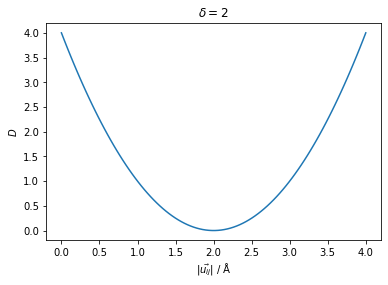

In [4]:
#hide_input
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,4,100)
plt.plot(x, (x-2)**2)
plt.xlabel("$|\\vec{u_{ij}}|$ / Å")
plt.ylabel("$D$")
plt.title("$\delta = 2$ Å")
plt.show()

## Angle restraints
Angles between any two interatomic vectors can also form the basis of a restraint. Typically this would be for a standard bond angle, though it could also be used to, for example, ensure that bonds on opposite sides of a ring are held parallel to each other. The penalty term $A$ is defined as:

$$ A = \left(\frac{\vec{u}_{ij}\cdot\vec{u}_{kl}}{|\vec{u}_{ij}||\vec{u}_{kl}|} - \cos{\alpha_{ijkl}}\right)^2 $$

where $\vec{u}_{ij}$ is the vector pointing from atom $i$ to atom $j$, $\vec{u}_{kl}$ is the vector pointing from atom $k$ to atom $l$ and $\alpha_{ijkl}$ is the angle between the interatomic vectors supplied by the user. If atom $i$ and atom $k$ are the same atom, then this equation gives a standard bond angle restraint. In the *GALLOP* code, the cosine of the user supplied angle is calculated and stored in advance for efficiency. The penalty term is bounded to values in the range 0 to 4 (inclusive).

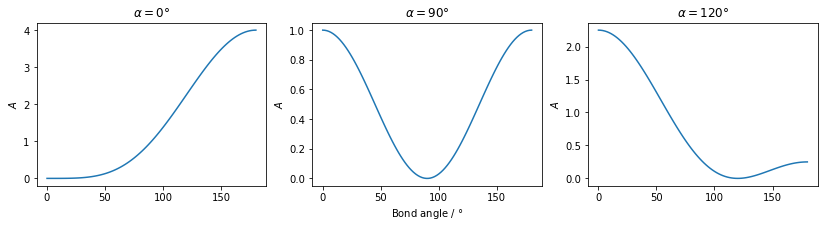

In [2]:
#hide_input
x = np.linspace(0,np.pi,100)
fig, ax = plt.subplots(1,3, figsize=(14,3))
ax[0].plot(np.rad2deg(x), (np.cos(x)-np.cos(0))**2)
ax[1].plot(np.rad2deg(x), (np.cos(x)-np.cos(np.pi/2))**2)
ax[2].plot(np.rad2deg(x), (np.cos(x)-np.cos(np.deg2rad(120)))**2)
#ax[0].set_xlabel("Bond angle / $ \degree $")
ax[1].set_xlabel("Bond angle / $ \degree $")
#ax[2].set_xlabel("Bond angle / $ \degree $")
ax[0].set_ylabel("$A$")
ax[1].set_ylabel("$A$")
ax[2].set_ylabel("$A$")

ax[0].set_title("$ \\alpha = 0 \\degree $")
ax[1].set_title("$ \\alpha = 90 \\degree $")
ax[2].set_title("$ \\alpha = 120 \\degree $")

plt.show()

## Torsion angle restraints
Torsion angles can also be used as a restraint. Whilst in general this will be a normal molecular torsion angle, it's not a requirement - any two pairs of intersecting planes can be used as the basis for a restraint. This could be used to ensure the relative orientations of separated planes of atoms if required. The penalty term, $T$ is defined as:

$$ T = \left(\frac{|\vec{u}_{jk}|\vec{u}_{ij}\cdot(\vec{u}_{jk}\times\vec{u}_{kl})}{|\vec{u}_{ij}\times\vec{u}_{jk}||\vec{u}_{jk}\times\vec{u}_{kl}|} - \sin{\tau_{ijkl}}\right)^2 + \left(\frac{(\vec{u}_{ij}\times\vec{u}_{jk})\cdot(\vec{u}_{jk}\times\vec{u}_{kl})}{|\vec{u}_{ij}\times\vec{u}_{jk}||\vec{u}_{jk}\times\vec{u}_{kl}|} - \cos{\tau_{ijkl}}\right)^2$$

where $\vec{u}_{ij}$ is the vector pointing from atom $i$ to atom $j$, $\vec{u}_{jk}$ is the vector pointing from atom $j$ to atom $k$, $\vec{u}_{kl}$ is the vector pointing from atom $k$ to atom $l$ and $\tau_{ijkl}$ is the torsion angle supplied by the user. As with the angle penalty term, the sine and cosine of the angle are calculated in advance and stored. This penalty term is also bounded to values in the range 0 to 4 (inclusive).

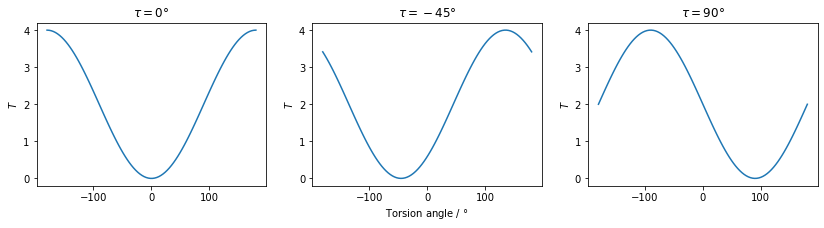

In [3]:
#hide_input
#plt.plot(np.rad2deg(x), (np.cos(x) - 1)**2 + (np.sin(x)**2))
#plt.xlabel("Torsion angle / $ \\degree $")
#plt.ylabel("T (where $ \\tau $ = 0 $ \\degree $)")
#plt.show()

x = np.linspace(-np.pi,np.pi,100)
fig, ax = plt.subplots(1,3, figsize=(14,3))
ax[0].plot(np.rad2deg(x), (np.cos(x) - np.cos(0))**2 + (np.sin(x) - np.sin(0))**2)
ax[1].plot(np.rad2deg(x), (np.cos(x) - np.cos(-np.pi/4))**2 + (np.sin(x)-np.sin(-np.pi/4))**2)
ax[2].plot(np.rad2deg(x), (np.cos(x) - np.cos(np.pi/2))**2 + (np.sin(x)-np.sin(np.pi/2))**2)

ax[1].set_xlabel("Torsion angle / $ \degree $")
ax[0].set_ylabel("$T$")
ax[1].set_ylabel("$T$")
ax[2].set_ylabel("$T$")

ax[0].set_title("$ \\tau = 0 \\degree $")
ax[1].set_title("$ \\tau = -45 \\degree $")
ax[2].set_title("$ \\tau = 90 \\degree $")
plt.show()

## Cost function and restraint weighting

Due to the generally small values of the restraint penalty terms relative to typical SDPD $\chi^2$ values, we need to weight the penalty terms so that their magnitude is sufficient to have a meaningful impact on the optimisation process. The approach that I ended up going with is to scale *all* of the penalty terms by the value of $\chi^2$ at every iteration so that their numerical values are comparable. I've also made it possible to further set the relative importance of each *individual* restraint by allowing users to set their own weights for each restraint. A weight of 1 indicates that the restraint has equal importance to $\chi^2$, weights less than or greater than 1 therefore enable the relative importance to be down- or up-weighted respectivly.

One thing that took me a little while to work out when I was implementing this (in retrospect this was an obvious thing I should have considered!) is that it's not OK to just multiply the tensor of penalty terms by the tensor of $\chi^2$ values. To see why, let's say that we have a structure with $a$ distance restraints, $b$ angle restraints and $c$ torsion restraints (and their associated weights, $w_a$, $w_b$, and $w_c$). Let's define the cost function that the local optimiser is trying to minimise as:

$$ C(\textbf{x}) = \chi^2(\textbf{x}) + \chi^2(\textbf{x})\left(\sum_a w_a{D(\textbf{x})} + \sum_b{w_bA(\textbf{x})} + \sum_c{w_cT(\textbf{x})}\right) $$

where $\textbf{x}$ represents the structural degrees of freedom. Let's simplify this using $R$ to represent the sum of all the weighted penalty terms:

$$ C(\textbf{x}) = \chi^2(\textbf{x})(1 + R(\textbf{x})) $$

By the product rule, the gradient of this function is:

$$ \nabla C(\textbf{x}) = (1 + R(\textbf{x}))\nabla \chi^2(\textbf{x}) + \chi^2(\textbf{x})\nabla R(\textbf{x}) $$

We can see that this could lead to problems because of the scaling of the gradient of $\chi^2$ by a factor of $1 + R(\textbf{x})$. In my testing this led to some very strange runs where it looked like progress was being made but then the optimisation behaviour resulted in strange oscillations in the value of $\chi^2$ and failure to obtain a solution on even simple problems.

The solution I landed on is to make a gradient-free copy of the $\chi^2$ tensor, i.e. a copy that is not a function of the degrees of freedom which can act purely as a numerical scaling factor. This converts the cost function into:

$$ C(\textbf{x}) = \chi^2(\textbf{x}) + \chi^2_{copy}\left(\sum_a w_a{D(\textbf{x})} + \sum_b{w_bA(\textbf{x})} + \sum_c{w_cT(\textbf{x})}\right) = \chi^2(\textbf{x}) + \chi^2_{copy}R(\textbf{x})) $$

and hence the gradient into:

$$ \nabla C(\textbf{x}) = \nabla \chi^2(\textbf{x}) + \chi^2_{copy} \nabla R(\textbf{x}) $$

This gives the optimisation behaviour that was expected and desired! In pytorch (the library used by *GALLOP* to perform the automatic differentiation), it's very easy to make the required gradient-free copy of the $\chi^2$ tensor:

```python
chisquared_copy = chisquared.detach().clone()
```

The ```.detach()``` method means that the computational graph associated with the tensor is removed, thus removing the dependence on the degrees of freedom. The ```.clone()``` method then copies the contents into the new tensor which can then act purely as a scaling factor.

# Using restraints in *GALLOP* for ring systems

Ok, so now we know how the restraints work, let's see how to include them in an SDPD attempt with *GALLOP*. We'll have a go both with the browser based GUI and the Python API. I've tried to make it relatively easy to use, though for the browser interface mode, it relies on having unique labels for all of the atoms within the Z-matrices. In Python mode, this isn't required, though I would suggest that it's still easier to use the atom label mode if you can! Now that *DASH* is [open source](https://github.com/ccdc-opensource/dash), it's very easy to generate suitable Z-matrices using *DASH*, starting from a CIF or MOL2 file where each atom has a unique label.

## Preparing models and restraints
I have been using Mercury to modify the structures and to break bonds and measure distances, angles and torsions. I then save the structure as a ```.mol2``` file, which can then be used with *DASH* to generate a Z-matrix. Occasionally, there'll be issues with the resultant Z-matrices using hydrogen atoms to define rotatable torsions. In such cases, I recommend deleting all hydrogen atoms prior to saving the mol2, then regenerating the Z-matrices. The hydrogen atoms can be added back in once the structure has solved.

As our example, we'll use the structure with CSD refcode IJUXUI, [a Schiff base with a 17-membered macrocyclic ring](https://link.springer.com/article/10.1134/S0022476615020080). Diffraction data and the structure can be downloaded [here](https://www.ccdc.cam.ac.uk/structures/Search?Ccdcid=ijuxui&DatabaseToSearch=Published) - I'm not sure if I can rehost the data here, but if you would like a copy of my fit files and models, feel free to message me and I'll send them over.

I opened the CSD entry for IJUXUI in Mercury and deleted the bond between ```O2``` and ```C8```. I also converted the two C=N double bonds into single bonds, and ended up with the following model, shown here with the atom labels involved with the cut bonds and restricted torsion angles, and hydrogen atoms hidden for clarity.

![IJUXUI cut model](./images/ijuxui_snipped_labels.png)

We are going to use the following restraints for our runs:

1. Distance restraint between ```O2``` and ```C8```, set to 1.44 Å
2. Torsion angle restraint using atoms ```C3```, ```C12```, ```N1``` and ```C13``` set to $180 \degree$
3. Torsion angle restraint using atoms ```C18```, ```C17```, ```N2``` and ```C16``` set to $180 \degree$

### *GALLOP* Learning rate

One thing I have found is that the learning rate finder built into *GALLOP* doesn't work as well when there are restraints in play, so my recommendation is to use the learning rate finder as normal with either a cut or a non-cut model, then use the learning rate obtained there when the restraints are active. A bit of experimentation might be needed to get a reasonable learning rate, however, as a general rule I choose the larger of the two value obtained.

For my fit files and the un-cut model, I obtained a learning rate of 0.0325, which I'll be using for the rest of this work.

## Browser interface

Start the *GALLOP* browser interface as normal (I'm using Kaggle, so my jobs are running on a P100 GPU), then upload the files needed. Modify the number of swarms and number of particles per swarm as you see fit, then we'll need to tweak a couple of settings. You may also wish to reduce the total number of iterations as this structure will solve very quickly - 5 *GALLOP* iterations with 10 swarms of 1000 particles should be more than sufficient.

**Learning rate** - open the Local Optimiser settings, then select "Show advanced options". Scroll down until you see "Find learning rate", and unselect that box. A new number input widget will appear, in here, set the learning rate to 0.0325 (or whatever value you obtain with your fit files). When you press enter, the display may show "0.03", but rest assured that the additional decimal places are still recorded internally - not that they make much difference in practice!

![](./images/manual_learning_rate.png)

**Restraints** - continue scrolling down the advanced local optimiser settings, until you see check boxes for restraints:

![](./images/restraint_check_boxes.png)

We'll be using both distance and torsion restraints, so select these. New input widgets will appear as a result:

![](./images/distance_restraint_inputs.png)

For the distance restraint, we only need one, so all we need to do is specify the atoms involved, the distance value we want to use, and the weight to apply to this restraint - we'll use a weight of 1.0:

For the torsionn restraints, we'll need two of these, so we modify the number of restraints to 2, and then the boxes allow us to specify each one:

![](./images/torsion_restraint_inputs.png)

As a brief aside, even though we aren't using them in this case, it's worth talking about using angle restraints in the browser interface. As *GALLOP* allows the flexibility to specify angle restraints between any two interatomic vectors, we can either supply 3 or 4 atom labels depending on what we want to do. For normal bond angles, we only provide three atom labels. For example, if we want the angle C2 - C1 - C3 (i.e. atom C1 in the middle) to be restrained to 120 degrees with a weight of 1.0, we would enter the following into the widget:
```
C2,C1,C3,120,1.0
```
Alternatively, if we have two interatomic vectors, for example C1 -> C2 and C3 -> C4, and we want them to be perpendicular with a weight of 0.5, we would use the following input:
```
C1,C2,C3,C4,90,0.5
```

#### Running *GALLOP*
Once the restraints and other settings have been entered, we're good to go! Start *GALLOP* as normal. On this structure with a P100 GPU accessed via Kaggle, this process took less than 3 minutes to complete:

![](./images/ijuxui_browser_interface_performance.png)

One thing that *GALLOP* allows is to save animations of the trajectory taken by each particle. This option slows things down a fair bit, but does produce some cool animations! Below, I've embedded an interactive animation (move, zoon etc using mouse) of the trajectory taken by the best performing particle during the first iteration of a different set of runs, with hydrogen atoms hidden for clarity. On the left, you see the whole unit cell, with the asymmetric unit shown on the right. You can see that the ring very rapidly reforms due to the action of the distance restraint.

In [6]:
#hide_input
from IPython.display import HTML

with open("files/ijuxui_restraint_iter_1_animation.html") as html:
    anim = html.read()
html.close()
HTML(anim)

The "shaking" that we see is due to the high learning rate in the middle of the local optimisation process, as per the [1-cycle](https://sgugger.github.io/the-1cycle-policy.html) learning rate policy used in *GALLOP* by default. This causes some oscillation due to the larger step sizes taken in the middle of the run.

## Python API

As with the browser interface, we'll set up our runs as normal then implement the restraints and fix the learning rate. I'll run these jobs on my PC (RTX 2060 GPU) to provide a comparison against the P100 for performance. If you're running this notebook yourself on Colab or Kaggle, you'll need to install *GALLOP* first by uncommenting the code cell below (hidden on blog).

As usual, we start with our library imports and creating a structure object. We then use the structure methods read in the diffraction data and add Z-matrices. For a more detailed overview of using the  Python API, see [this post](https://mspillman.github.io/blog/gallop/pxrd/python/2021/11/03/Solving-structures-with-GALLOP-Python-API.html).

In [5]:
#collapse_hide
# Uncomment the line below, then run this cell to install GALLOP on Colab or Kaggle
#!git clone https://github.com/mspillman/gallop.git && cd gallop && pip install .

In [1]:
from gallop.structure import Structure
from gallop.optim import local
from gallop.optim import Swarm

mystructure = Structure(name="IJUXUI_cut_with_restraints", ignore_H_atoms=True)
mystructure.add_data("files/IJUXUI.sdi", source="DASH")
mystructure.add_zmatrix("files/IJUXUI_cut_1.zmatrix")

Added Z-matrix with Filename: files/IJUXUI_cut_1.zmatrix
Non-H atoms: 29
refinable torsions: 14
Degrees of freedom: 21 (7 + 14)


Now let's add the restraints. The below code cell shows how to do this using the unique atom-label approach that was also used in the browser interface - we pass a dictionary to the function containing key/value pairs corresponding to the atom labels, the desired value for the distance/angle/torsion and the weight for the restraint.

In [2]:
mystructure.add_restraint({"type" : "distance",
                        "atom1" : "O2",
                        "atom2" : "C8",
                        "value" : 1.44,
                        "weight" : 1.0})

mystructure.add_restraint({"type" : "torsion",
                        "atom1" : "C3",
                        "atom2" : "C12",
                        "atom3" : "N1",
                        "atom4" : "C13",
                        "value" : 180.0,
                        "weight" : 1.0})

mystructure.add_restraint({"type" : "torsion",
                        "atom1" : "C18",
                        "atom2" : "C17",
                        "atom3" : "N2",
                        "atom4" : "C16",
                        "value" : 180.0,
                        "weight" : 1.0})

#### Angle restraints

Whilst we aren't using them here, for an angle restraint, we need to specify two interatomic vectors. If we want this to be a standard bond angle, then atom1 and atom3 need to be the same atom, for example, in a structure where the angle C2 - C1 - C3 is 120 degrees, then we want the angle between the vectors C1 -> C2 and C1 -> C3 to be 120 degrees, so we would use the following command:

```python
mystructure.add_restraint({"type" : "angle",
                        "atom1" : "C1",
                        "atom2" : "C2",
                        "atom3" : "C1",
                        "atom4" : "C3",
                        "value" : 120.0,
                        "weight" : 1.0})
```

If we weren't working with a normal bond angle, then to specify a restraint between two interatomic vectors, e.g. C1 -> C2 and C3 -> C4, then we would use something like this:

```python
mystructure.add_restraint({"type" : "angle",
                        "atom1" : "C1",
                        "atom2" : "C2",
                        "atom3" : "C3",
                        "atom4" : "C4",
                        "value" : 120.0,
                        "weight" : 1.0})
```

#### Other input methods

If we didn't have unique atom labels for each of the atoms in the asymmetric unit, we can instead specify the atoms involved by referring to their associated Z-matrix and the position of the atom within the Z-matrix. For example, a distance restraint between the 4th atom in zmatrix_1.zmatrix and the 8th atom in zmatrix_3.zmatrix, with a distance of 3.0 Å and weight of 0.5 can be added via:
```python
mystructure.add_restraint({"type" : "distance",
                        "zm1":"zmatrix_1.zmatrix", "atom1":4,
                        "zm2":"zmatrix_3.zmatrix", "atom2":8,
                        "value":3,
                        "weight":0.5})
```
Alternatively, assuming that the zmatrices were added sequentially starting with zmatrix_1.zmatrix:
```python
mystructure.add_restraint({"type":"distance",
                        "zm1":1, "atom1":4,
                        "zm2":3, "atom2":8,
                        "value":3.0,
                        "weight":0.5})
```
The same principles apply to angle and torsion restraints, they just require changing the "type" key/value pair, as well as additional entries for atoms 3 and 4, and their associated ZMs. For example:
```python
mystructure.add_restraint({"type":"torsion",
                        "zm1":2, "atom1":4,
                        "zm2":2, "atom2":8,
                        "zm3":2, "atom3":12,
                        "zm4":2, "atom4":14,
                        "value": 130.0,
                        "weight": 0.5})
```

#### Running *GALLOP*
Now that we have our restraints specified, let's set up our *GALLOP* parameters and loop, then run it. We'll need to remember to pass the ```use_restraints = True``` bool to the local optimiser function. The easiest way to do this is to modify the value in the ```minimiser_settings``` dictionary.

Again, we'll go for 10 swarms of 1000 particles, and run *GALLOP* for 5 iterations.

In [5]:
import time
swarm = Swarm(mystructure, n_particles=10000, n_swarms=10)
external, internal = swarm.get_initial_positions()

# Get the default minimiser settings
minimiser_settings = local.get_minimiser_settings(mystructure)

# Set the learning rate to what we obtain from a rigid ring model and learning rate finder
minimiser_settings["learning_rate"] = 0.0325

# Toggle this run to use the restraints we added
minimiser_settings["use_restraints"] = True

# Set the total number of iterations for the GALLOP run
gallop_iters = 5
start_time = time.time()
# The main GALLOP loop
for i in range(gallop_iters):
    # Local optimisation of particle positions
    result = local.minimise(mystructure, external=external, internal=internal,
                run=i, start_time=start_time, **minimiser_settings)
    # Particle swarm update generates new positions to be optimised
    external, internal = swarm.update_position(result=result)

GALLOP iter 0005 LO iter 0500 min chi2 86.8: 100%|██████████| 500/500 [00:48<00:00, 10.37it/s] 


As you can see, we hit approximately the same $\chi^2$ value as we did with the browser interface, though due to the use of my desktop PC rather than a cloud-based GPU, things took a little longer.

As a point of comparison, let's rerun the jobs above, this time without the restraints. We should see a significant difference in the rate of convergence.

In [4]:
# Create a new swarm object so we don't start from the end point of the last run
swarm = Swarm(mystructure, n_particles=10000, n_swarms=10)
external, internal = swarm.get_initial_positions()

# We'll use the same settings as the previous run
# However, we'll turn of the restraints for this run.
minimiser_settings["use_restraints"] = False

# Set the total number of iterations for the GALLOP run
gallop_iters = 5
start_time = time.time()
# The main GALLOP loop
for i in range(gallop_iters):
    # Local optimisation of particle positions
    result = local.minimise(mystructure, external=external, internal=internal,
                run=i, start_time=start_time, **minimiser_settings)
    # Particle swarm update generates new positions to be optimised
    external, internal = swarm.update_position(result=result)

GALLOP iter 0005 LO iter 0500 min chi2 104.9: 100%|██████████| 500/500 [00:45<00:00, 10.89it/s]


As we can see, without restraints, we don't reach the bottom of the global minimum within the 5 iterations alloted (though we get close - the final CIF gave a relatively low RMSD of 0.204 Å against the published structure). Whilst this is a small sample size, it does seem like restraints are providing a significant benefit.

However, using restraints comes at a cost: as we can see, using the restraints results in an approximately 7 % increase in the time taken to perform the runs. This is simply because there are more operations that *GALLOP* has to carry out in order to calculate the restraint penalty term values and their associated gradients. However, this computational cost is fairly small and hopefully it's obvious that even for relatively simple problems like the one we are tackling here, the benefits outweigh the increased computational cost!

# Using restraints in *GALLOP* for stereochemistry

The restraints we've been working with so far are not limited in application to ring systems. In this section, we'll see how the use of restraints can save a significant amount of user effort in model preparation and testing in the case of a structure with multiple chiral centres of unknown (relative) configuration.

An asymmetric unit containing $n$ chiral centres of unknown configuration leads to up to $2^n$ unique combinations of R and S at each of the centres. {% fn 1 %} {{ "Meso structures means that in practice, it may not always be as high as $2^n$" | fndetail: 1 }} Enantiomers are indistinguishable in standard PXRD experiments, this therefore means that there are $2^{n-1}$ configurations of R and S that each require a model to be prepared and tested. Given the exponential growth in the number of models with $n$, this could rapidly lead to very large numbers of runs being required!

So, how do restraints help? Well, if we break two of the bonds at each chiral centre, the separated fragments will be able to move independently, and be refined to their correct relative positions. However, as was the case with rings, breaking bonds leads to an increase in the number of degrees of freedom that need to be determined. Therefore, the inclusion of restraints ensures that the additional degrees of freedom are limited to only taking on values that reform the bonds that were broken, thus ensuring both that the correct molecule is obtained after optimisation and also that the optimisation process doesn't take an inordinate amount of time!

In the article we published, we took a look at the structure of trandolapril, [published by Reid et al](https://discovery.ucl.ac.uk/id/eprint/1519753/), which has CSD refcode IQISAE01. This molecule has 5 chiral centres:

![2D molecular structure of trandolapril](./images/Trandolapril_structure.png)

In the event that the configuration at each centre was unknown, then up to 16 alternative models would require construction and testing. With our approach, a single model is cut to produce 5 separate fragments, which are then connected with restraints:

![Cut model of trandolapril](./images/iqisae_snipped.png)

In a head-to-head comparison of the performance between the correct fixed model and the cut and restrained model, we saw a reduction in the rate of success from 44 % to 17 % - a factor of approximately 2.5. However, what does this reduction in success rate mean in practice?

If you were using *GALLOP* and a P100 GPU (16 GB memory) accessed via Kaggle to solve the structure, we could expect to fit approximately 10 swarms of 1000 particles in the GPU memory. With a 17 % success rate, a single run of 20 iterations with 10 swarms of 1000 particles using the cut and restrained model has an 84.5 % probability of solving the structure. With the correct uncut model, which has a 44 % swarm success rate, the probability of success with the same number of iterations, swarms and particles increases to 99.7 %. Therefore, let's conservatively assume that we need two runs with the cut and restrained model to be reasonably sure of getting at least one solution (20 swarms would give 97.6 % probability of success), but only one run is needed if we are using a model with the correct relative configuration. This conservative assumption still means that the normal model building approach requires 8 times the number of runs to obtain a solution than the cut and restrain approach. This approach therefore offers a significant improvement in the time taken to obtain a solution, even without considering the onerous task of preparing 16 different input models!

One other thing to note is that if the absolute stereochemical configuration of *any* of the chiral centres is known, then by leaving that centre intact, the absolute configuration all *other* centres can be obtained directly by refining with the cut and restrain approach we discussed above. For PXRD experiments, this seems like a logical method to speed up the approach to absolute configuration determination described [here](https://onlinelibrary.wiley.com/doi/abs/10.1002/anie.201713168).

## Other applications

Restraints in general enable the inclusion of additional information into the SDPD process, reducing the search space and (hopefully) increasing the probability of success. The information used to specify the restraints can come from a wide variety of sources. Whilst we have focussed here on using known bond lengths and expected torsion angle values, we could also include information from a multitude of other sources.

For example, solid state NMR experiments can be used to obtain intramolecular end-to-end distances. As was [demonstrated by Middleton et al](https://pubs.rsc.org/en/content/articlelanding/2002/cc/b204289d/unauth), these distances can be used to force the molecualar fragments being optimised to adopt conformations close to that at the global minimum during the early stages of optimisation, significatly reducing the time taken to solve the crystal structure.

Crystallographic databases can also be used to derive both positional and conformational information. For example, protonated quarternary ammonium cations and chloride counter ions are commonly found approximately 3 Å apart, providing the basis of an easily applied restraint. In two previous posts, we looked at solving the crystal structure of verapamil hydrochloride, which includes this feature. I ran 20 swarms of 1000 particles for 10 iterations, both with and without the Cl1 to N1 3 Å restraint applied, with a weight of 1. The learning rate was set to 0.05 in both cases. With restraints, 6 swarms reached the global minimum (30 %), whilst without, only 2 swarms (10 %) obtained the solution. This is a very small sample size, but I still think it's reasonable to suggest that the restraint provides some benefit for very little effort! [Hydrogen-bond propensity calculations](https://pubs.rsc.org/en/content/articlelanding/2013/ce/c3ce40367j) could also be used to inform restraints on the basis of likely intermolecular contact distances.

The use of database-derived torsion angle distribution information is well established in SDPD via the use of techniques such as the Mogul Distribution Bias (MDB) which has been shown to [greatly improve success rates in *DASH*](http://scripts.iucr.org/cgi-bin/paper?po5105). It worth noting that you can also use MDB information in *GALLOP*. This is described in the context of the [browser interface](https://mspillman.github.io/blog/gallop/pxrd/python/2021/11/02/Solving-structures-with-GALLOP-browser-interface.html#Fitting-data-with-DASH) and [Python API](https://mspillman.github.io/blog/gallop/pxrd/python/2021/11/03/Solving-structures-with-GALLOP-Python-API.html#Initialise-a-Particle-Swarm) in other posts. Other torsional information could be manually included via restraints if desired.

Recent advances in the field of [protein folding](https://www.deepmind.com/research/highlighted-research/alphafold) allow both protein conformations and intramolecular residue contact distances to be predicted. Clearly such information could also be used to inform restraints for SDPD applications.

# Conclusions

In this post, we've seen how to use restraints in *GALLOP* to help with solving structures with unknown ring conformations and structures with multiple stereochemical centres of unknown relative configuration.